In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import datetime
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [119]:
df = pd.read_csv('./data/seoul-bike-data.csv', encoding='unicode_escape')
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


# Data Exploration

In [120]:
display(df.info())
display(df.describe().T)
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

None

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
Temperature(°C),8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
Humidity(%),8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
Wind speed (m/s),8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
Visibility (10m),8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
Dew point temperature(°C),8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
Solar Radiation (MJ/m2),8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
Rainfall(mm),8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
Snowfall (cm),8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80


Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

At first glance, the data appears to be clean, most variables are well typed. We can also see that some columns have class values, which we'll need to encode later.

Here we can see that we'll need to change the type of the "Date" column, as well as encode the "Season", "Holiday" and "Functional Day" columns.
We can also see that we'll need to normalize the values to ensure consistency in their interpretation.
Finally, there are no missing values

In [121]:
hourly_counts = df.groupby('Date')['Hour'].nunique()
dates_with_incomplete_hours = hourly_counts[hourly_counts != 24]
print("Number of dates with incomplete hourly data:", len(dates_with_incomplete_hours))

Number of dates with incomplete hourly data: 0


So we have verified that for every date in the dataset, we have 24 different hourly records. This is important because we'll be using the date and hour columns to index the dataset.

In [122]:
min_date = df['Date'].min()
max_date = df['Date'].max()
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
missing_dates = all_dates.difference(df['Date'])
print(f"There are {len(missing_dates)} missing dates in the range")

There are 0 missing dates in the range


# Data Cleaning

We know now that there are no missing dates in the range, so we can proceed to index the dataset by date and hour.

In [123]:
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['WeekDay']=df['Date'].dt.day_name()
df.drop(columns=['Date'], inplace=True)

We can now drop the "Date" column, as we have extracted all the information we need from it.
It will be more easy to analyze the data by day and month now. Also, we add a column for the day of the week, which will be useful for the analysis.


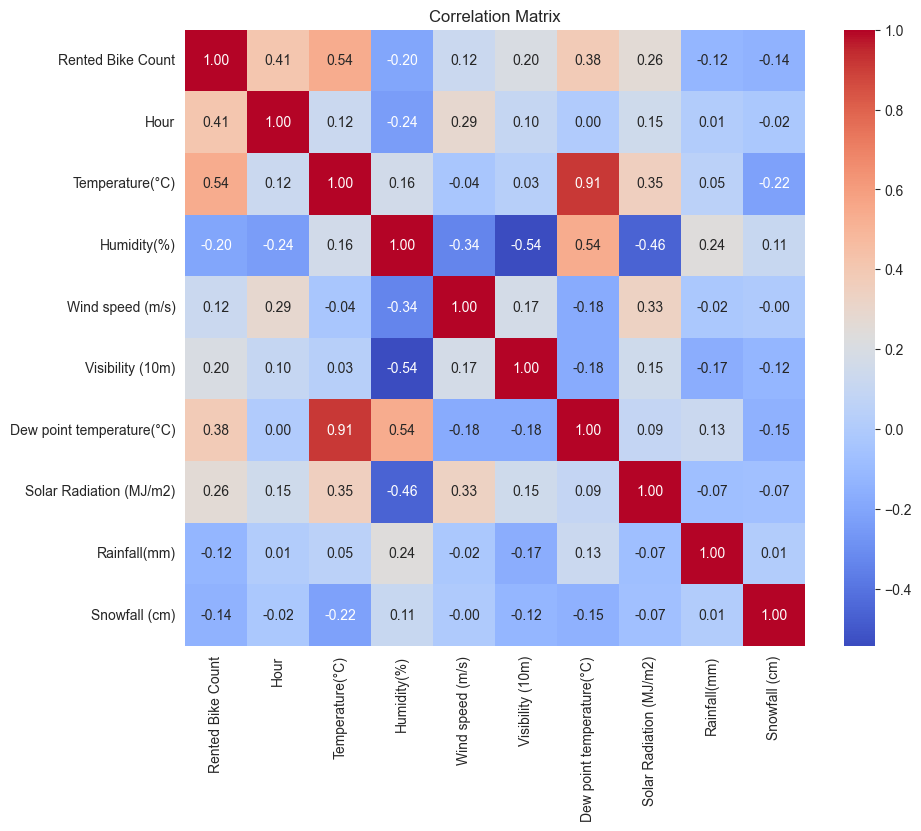

In [124]:
# Select only numerical columns for correlation matrix
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Thanks to this correlation matrix, we can see that there is a strong correlation between the temperature and the dew point temperature, which is to be expected. Thus we can delete the dew point temperature column.

In [125]:
df = df.drop(columns=['Dew point temperature(°C)'])

We have to check if there are any outliers in the data. And delete them if necessary.

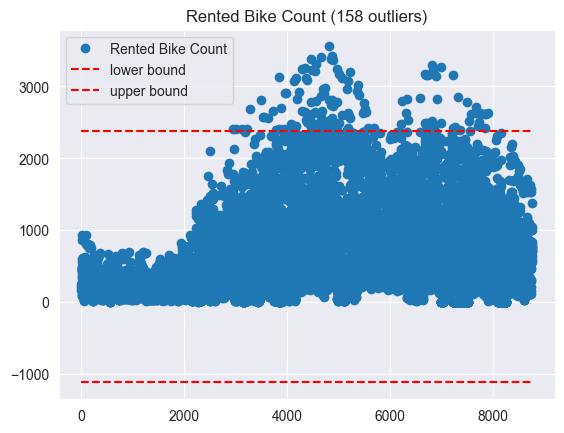

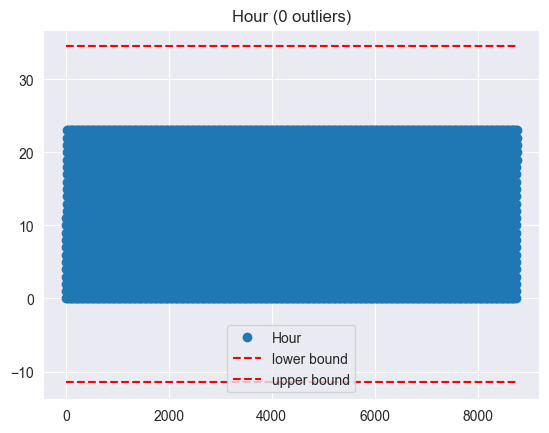

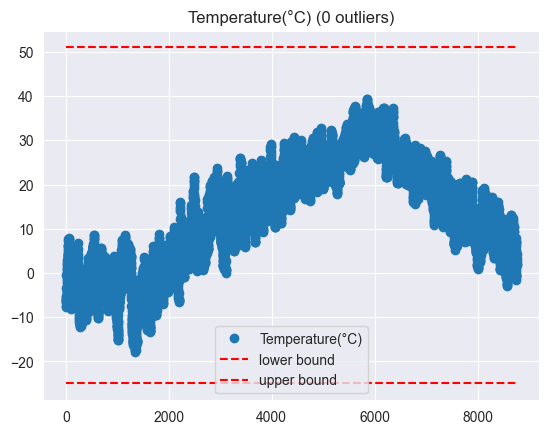

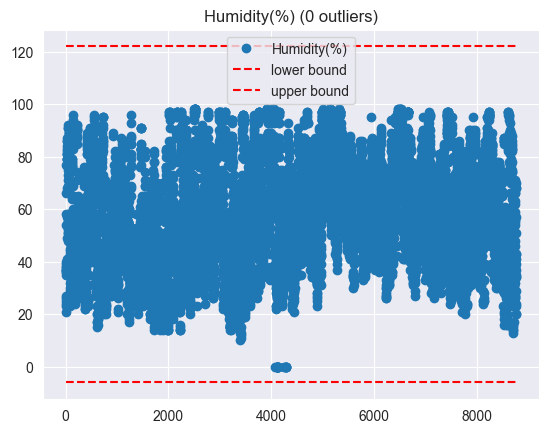

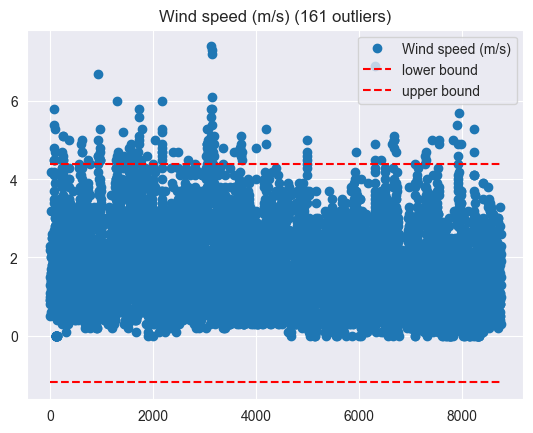

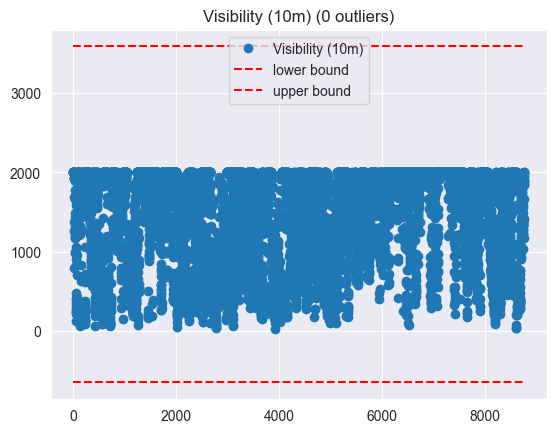

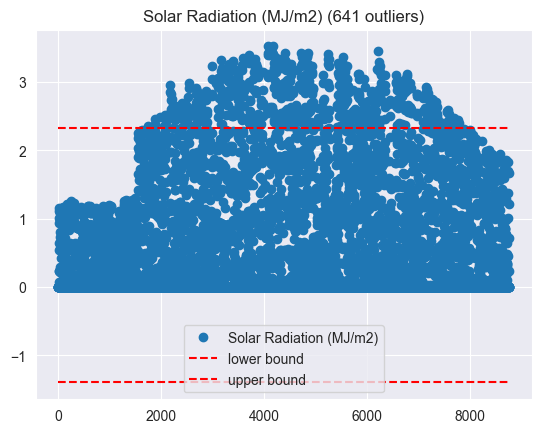

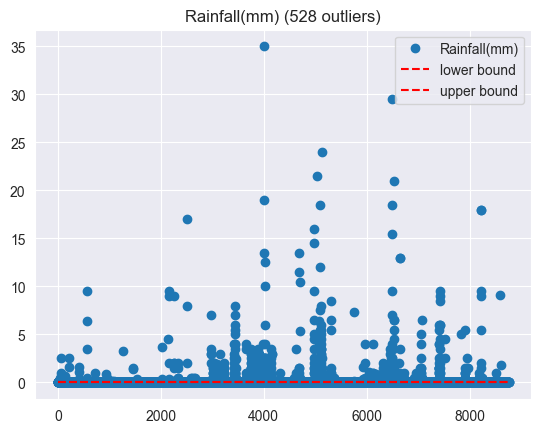

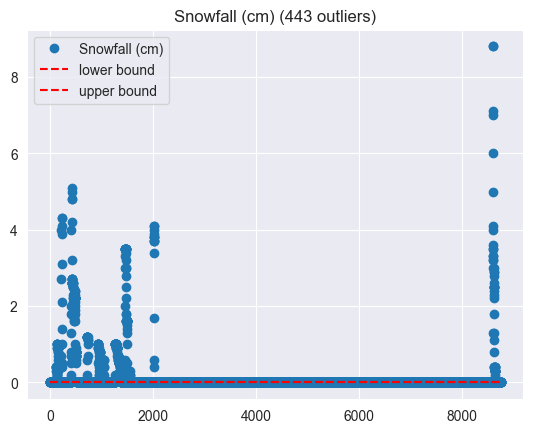

{'Rented Bike Count': 158,
 'Hour': 0,
 'Temperature(°C)': 0,
 'Humidity(%)': 0,
 'Wind speed (m/s)': 161,
 'Visibility (10m)': 0,
 'Solar Radiation (MJ/m2)': 641,
 'Rainfall(mm)': 528,
 'Snowfall (cm)': 443}

In [126]:

outlier_summary = {}
numerical_cols = numerical_cols.drop("Dew point temperature(°C)")
# Loop through each column in the dataset
for column in numerical_cols:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count the number of outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_count = outliers.shape[0]
    plt.plot(df[column], 'o', label=column)
    plt.plot([0, len(df)], [lower_bound, lower_bound], 'r--', label='lower bound')
    plt.plot([0, len(df)], [upper_bound, upper_bound], 'r--', label='upper bound')
    plt.legend()
    plt.title(f'{column} ({outlier_count} outliers)')
    plt.show()
    # Store the outlier count for each column
    outlier_summary[column] = outlier_count

outlier_summary

We see that there are some outliers on a few columns but there all are not too far from the upper bound. So we decide to keep them. They might be important for the model. Indeed, these outliers don't seem to be errors, but rather extreme values that are possible in real life.

In [127]:
df.to_csv("./data/seoul-bike-data-clean-for-dataviz.csv")

# Data Preparation

For the modelling part, we'll need to encode the categorical variables.

In [128]:
df['Holiday'] = df['Holiday'].map({'Holiday': 1, 'No Holiday': 0})
df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
dict_day_of_week={'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
df['WeekDay']=df['WeekDay'].map(dict_day_of_week)
dict_season = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Autumn': 4}
df['Seasons'] = df['Seasons'].map(dict_season)

In [129]:
from sklearn.preprocessing import StandardScaler
import pickle
columns_to_scale = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)',  'Rainfall(mm)', 'Snowfall (cm)']
features_scaler = StandardScaler()
df[columns_to_scale] = features_scaler.fit_transform(df[columns_to_scale])
target_feature = StandardScaler()
print(df[['Rented Bike Count']].head())
df['Rented Bike Count'] = target_feature.fit_transform(df[['Rented Bike Count']])
print(df[['Rented Bike Count']].head())
pickle.dump(features_scaler, open('./features_scaler.pkl', 'wb'))
pickle.dump(target_feature, open('./target_scaler.pkl', 'wb'))

   Rented Bike Count
0                254
1                204
2                173
3                107
4                 78
   Rented Bike Count
0          -0.698650
1          -0.776175
2          -0.824240
3          -0.926571
4          -0.971535


We have decided to normalize the data, in order to have a better accuracy for the model. Even if we use a random forest model, which is a scale-invariant model, we stiil need to normalize the data to minimize the RMSE and MAE.
We also encone the categorical variables, in order to have a better accuracy for the model.
To finish we save the two scaler in order to use them in the prediction part.

In [130]:
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Day,Month,Year,WeekDay
0,-0.698650,0,-1.513957,-1.042483,0.458476,0.925871,-0.655132,-0.1318,-0.171891,1,0,1,1,12,2017,5
1,-0.776175,1,-1.539074,-0.993370,-0.892561,0.925871,-0.655132,-0.1318,-0.171891,1,0,1,1,12,2017,5
2,-0.824240,2,-1.580936,-0.944257,-0.699556,0.925871,-0.655132,-0.1318,-0.171891,1,0,1,1,12,2017,5
3,-0.926571,3,-1.597680,-0.895144,-0.796059,0.925871,-0.655132,-0.1318,-0.171891,1,0,1,1,12,2017,5
4,-0.971535,4,-1.580936,-1.091596,0.554978,0.925871,-0.655132,-0.1318,-0.171891,1,0,1,1,12,2017,5


In [131]:
df.to_csv('./data/seoul-bike-data-clean-for-model.csv', index=False)